In [1]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),               # Random crop + resize to 224x224
    transforms.RandomHorizontalFlip(),               # Randomly flip images horizontally
    transforms.ColorJitter(0.2, 0.2, 0.2),            # Random brightness, contrast, saturation
    transforms.RandomRotation(15),                   # Randomly rotate images
    transforms.ToTensor(),                           # Convert image to tensor
    transforms.Normalize(                            # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Only resize and center crop for validation
val_transform = transforms.Compose([
    transforms.Resize(256),                          # Resize shortest side to 256
    transforms.CenterCrop(224),                      # Center crop to 224x224
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize(                            # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

data_path = "Downloads/archive/PetImages"  # Make sure this path is correct

# Load full dataset without transform for now
full_dataset = ImageFolder(root=data_path)

# Split dataset into train/val (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply transforms to each split manually (this is critical!)
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

print(f"Total images: {len(full_dataset)}")
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Class names: {full_dataset.classes}")

Total images: 24998
Training set: 19998 images
Validation set: 5000 images
Class names: ['Cat', 'Dog']


In [4]:
from torch.utils.data import DataLoader

batch_size = 32  # Adjust depending on memory

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Peek at a batch
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")  # Expected: [32, 3, 224, 224]
print(f"Labels batch shape: {labels.shape}")
print(f"Labels: {labels}")

Image batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Labels: tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 0])


In [5]:
# Defining the model
import torch.nn as nn
import torch.optim as optim

# Define CNN model with dropout
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):   #classes caan be changed; think of the function as a blueprint
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.6)  # Dropout for regularization
        self.fc1 = nn.Linear(32 * 56 * 56, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))    # [B, 16, 112, 112]
        x = self.pool(self.relu(self.conv2(x)))    # [B, 32, 56, 56]
        x = x.view(x.size(0), -1)                  # Flatten: [B, 32*56*56]
        x = self.dropout(self.relu(self.fc1(x)))   # Apply dropout before FC2
        x = self.fc2(x)
        return x

# Instantiate model
model = SimpleCNN(num_classes=2).to(device)

# Loss and optimizer (with weight decay for L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


In [6]:
# Model Training
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50):
    import time

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()

        # ----- Training Phase -----
        model.train()
        running_train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # ----- Validation Phase -----
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # ----- Logging -----
        duration = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_accuracy:.2f}%, "
              f"Time: {duration:.1f}s")

    return train_losses, val_losses, val_accuracies

In [7]:
# Model Evaluation
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [8]:
# Output for training & evaluation
# Train the model and track performance
train_losses, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50
)


/home/hipe2/anaconda3/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch [1/50] - Train Loss: 0.6745, Val Loss: 0.5739, Val Acc: 72.40%, Time: 94.1s
Epoch [2/50] - Train Loss: 0.5493, Val Loss: 0.5242, Val Acc: 73.82%, Time: 93.5s
Epoch [3/50] - Train Loss: 0.4714, Val Loss: 0.5046, Val Acc: 76.20%, Time: 93.2s
Epoch [4/50] - Train Loss: 0.4054, Val Loss: 0.5232, Val Acc: 76.86%, Time: 93.2s
Epoch [5/50] - Train Loss: 0.3322, Val Loss: 0.5108, Val Acc: 77.52%, Time: 92.9s
Epoch [6/50] - Train Loss: 0.2720, Val Loss: 0.5759, Val Acc: 77.44%, Time: 93.6s
Epoch [7/50] - Train Loss: 0.2290, Val Loss: 0.6379, Val Acc: 75.96%, Time: 93.4s
Epoch [8/50] - Train Loss: 0.1967, Val Loss: 0.6467, Val Acc: 77.34%, Time: 93.2s
Epoch [9/50] - Train Loss: 0.1729, Val Loss: 0.6936, Val Acc: 77.06%, Time: 93.1s
Epoch [10/50] - Train Loss: 0.1559, Val Loss: 0.7829, Val Acc: 77.38%, Time: 93.1s
Epoch [11/50] - Train Loss: 0.1378, Val Loss: 0.7940, Val Acc: 76.84%, Time: 92.8s
Epoch [12/50] - Train Loss: 0.1257, Val Loss: 0.8429, Val Acc: 77.46%, Time: 93.0s
Epoch [13/50]

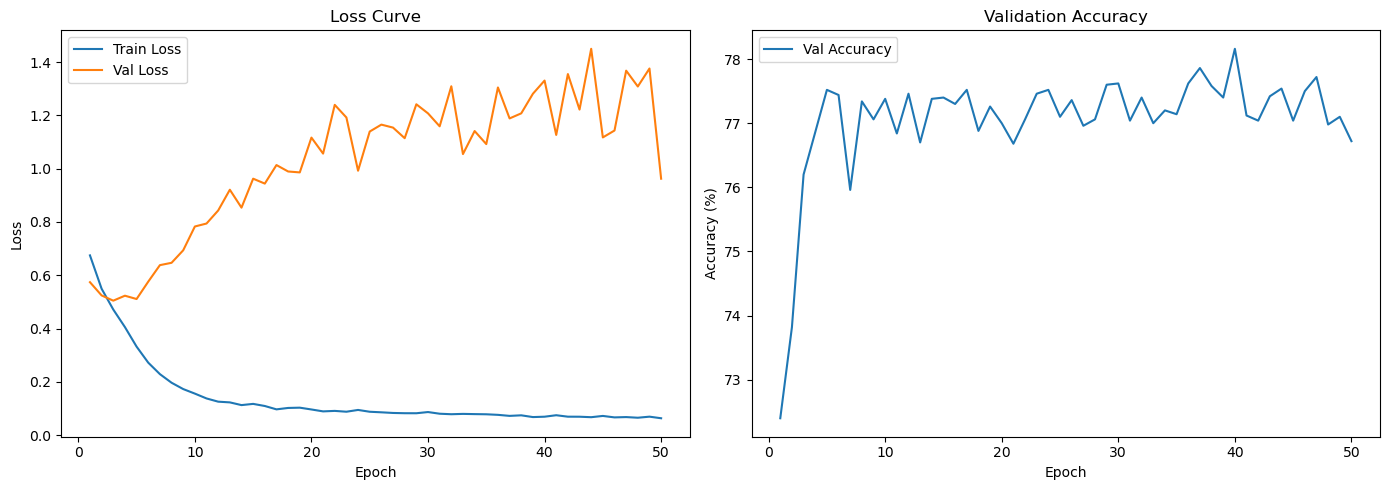

In [9]:
#plot loss + accuracy
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()